##### Author: Pablo Iañez Picazo 
##### Biomedical Data Science lab, ISGlobal

In [1]:
# Load all the necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.cluster import KMeans

import random
import umap

random.seed(22)
sns.set_style("ticks")

# Supress all warnings (bcoz they're quite annoying)
import warnings

warnings.filterwarnings("ignore")

import sys

sys.path.append("/home/pianez/phd/projects/hsc_nucleus/hsc_rhoa")
from methods import hsc_spatial_stats as hsc
from globals import batches_out, new_names

2024-07-26 11:45:44.934278: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-26 11:45:44.961914: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 11:45:44.961941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 11:45:44.962725: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-26 11:45:44.967691: I tensorflow/core/platform/cpu_feature_guar

In [2]:
sns.set(rc={"figure.figsize": (20, 16)})
sns.set_style("whitegrid")

In [3]:
# ------------------------ Set up some parameters --------------------------- #
# Image resolution after resizing, which is 5 micrometers per pixel
res = 0.1
# cluster forming threshold - threshold at which intensities above this value
# will be considered belonging to a DAPI-Intense Region (DIR)
# Intensities to 0.6 are the one in the quantile 0.80 in young, old and treated
cft = 0.6
normalization = "z_score"
folder = "../data/preprocessed/"
conditions = [
    "young",
    "aged",
    "aged_treated_RhoAi",
    "myeloid_progenitors",
]

palette = {
    "Young": (0.00392, 0.45098, 0.69803),
    "Aged": (0.00784, 0.61960, 0.45098),
    "Aged + Ri": (0.8, 0.47058, 0.73725),
    "MP": (0.76868, 0.30588, 0.32156),
}

In [4]:
nuc_df = pd.read_csv(
    f"results/z_score_nuclei_3d_res{res}_cf{cft}_filt_df.csv", index_col=0
)
nuc_df = hsc.fix_labels(nuc_df)

In [5]:
MP_batches = [
    "20210120_PHF8-OldAB",
    "20210414_KDM4B",
    "20210429_H3K9me2-Cy3",
    "20211203_KDM3A",
    "20210421_PHF8-OldAB",
    "20210916_KDM3A_2",
    "20201109_KDM4B",
    "20210126_KDM4A_2",
    "20210831_H3K9me2",
    "20210122_PHF8-NewAB",
    "20210114_KDM4B",
    "20210430_PHF8-OldAB",
    "20210415_KDM4A",
    "20210126_KDM4A",
    "20210121_PHF8-NewAB",
    "20210505_H3K9me2",
    "20210112_H3K9me2",
    "20210916_KDM3A",
]

In [6]:
print(nuc_df.shape)
nuc_df = nuc_df[~nuc_df["im_batch"].isin(batches_out)]
print(nuc_df.shape)

(837, 92)
(780, 92)


In [8]:
features = [
    "volume",
    "width",
    "length",
    "height",
    "height deviation",
    "aspect ratio",
    "major axis length",
    "minor axis length",
    "min intensity",
    "max intensity",
    "solidity",
    "surface area",  # highly correlated with volume
    "sphericity",
    "invagination proportion",  # highly correlated with solidity
    "DIRs volume",
    "DIRs width",
    "DIRs length",
    "DIRs height",
    "intensity 0-0.5µm",
    "intensity 1-1.5µm",
    "intensity ratio",
    "DIRs aspect ratio",
    "DIRs surface area",
    "DIRs major axis length",
    "DIRs sphericity",
    "DIRs surface/volume",
    "DIRs mean intensity",
    "DIRs max intensity",
    "DIRs solidity",
    "DIRs centroid distance to border",  # highly correlated with DIRs_mean_distance2border
    "DIRs distance to border",
    "number of DIRs",
    "largest slide area",  # highly correlated with 2D_slide_volume
    "largest slide major axis length",
    "largest slide minor axis length",
    "largest slide perimeter",  # highly correlated with 2D_slide_area
    "largest slide roundness",  # highly correlated with 2D_slide_EOP
    "largest slide compactness",
    "largest slide EOP",
    "condition",
    "im_path",
    "im_batch",
    "im_nuc",
]


sig_f_both = [
    "volume",
    "width",
    "length",
    "aspect ratio",
    "minor axis length",
    "min intensity",
    # "surface_area",
    "sphericity",
    "DIRs volume",
    "DIRs length",
    # "DIRs_height",
    "intensity 0-0.5µm",
    # "int_1.0-1.5",
    "intensity ratio",
    "DIRs major axis length",
    "DIRs mean intensity",
    # "DIRs_max_intensity",
    "DIRs sphericity",
    # "DIRs_surface/volume",
    "DIRs solidity",
    "number of DIRs",
    # "DIRs_centroid_distance2border",
    "DIRs distance to border",
    # "2D_slide_area",
    # "largest slide major axis length",
    "largest slide minor axis length",
    # "2D_slide_perimeter",
    # "2D_slide_roundness",
    "largest slide EOP",
]

In [9]:
subset_df = nuc_df[
    nuc_df["condition"].isin(["Young", "Aged", "Aged + Ri", "MP"])
]
subset_df = subset_df.rename(columns=new_names)
subset_df = subset_df[features]
subset_df["DIRs distance to border"] = (
    subset_df["DIRs distance to border"] * res
)

In [10]:
subset_df.condition.value_counts()

MP           254
Young        177
Aged         164
Aged + Ri    144
Name: condition, dtype: int64

In [11]:
corrmat = subset_df[sig_f_both].corr()
corrmat = corrmat.rename_axis(None).rename_axis(None, axis=1)
corrmat = corrmat.stack().reset_index()
corrmat.columns = ["var_1", "var_2", "correlation"]
corrmat = corrmat[corrmat["correlation"] != 1]
corrmat.sort_values(by="correlation", ascending=False).head(20)

var_1                            var_2  \
17                            volume  largest slide minor axis length   
323  largest slide minor axis length                           volume   
36                             width  largest slide minor axis length   
324  largest slide minor axis length                            width   
4                             volume                minor axis length   
76                 minor axis length                           volume   
1                             volume                            width   
19                             width                           volume   
38                            length                           volume   
2                             volume                           length   
55                            length  largest slide minor axis length   
325  largest slide minor axis length                           length   
285                   number of DIRs                           volume   
15                            volume                   number of DIRs   
159                      DIRs length                      DIRs volume   
141                      DIRs volume                      DIRs length   
216           DIRs major axis length                      DIRs volume   
144                      DIRs volume           DIRs major axis length   
199                  intensity ratio                intensity 0-0.5µm   
181                intensity 0-0.5µm                  intensity ratio   

     correlation  
17      0.788275  
323     0.788275  
36      0.782254  
324     0.782254  
4       0.772212  
76      0.772212  
1       0.768584  
19      0.768584  
38      0.762113  
2       0.762113  
55      0.757626  
325     0.757626  
285     0.731752  
15      0.731752  
159     0.727126  
141     0.727126  
216     0.711960  
144     0.711960  
199     0.696804  
181     0.696804

In [12]:
corrmat.sort_values(by="correlation", ascending=False).tail(20)

var_1                            var_2  \
142                      DIRs volume                intensity 0-0.5µm   
178                intensity 0-0.5µm                      DIRs volume   
281                    DIRs solidity                   number of DIRs   
299                   number of DIRs                    DIRs solidity   
74                      aspect ratio  largest slide minor axis length   
326  largest slide minor axis length                     aspect ratio   
206                  intensity ratio          DIRs distance to border   
314          DIRs distance to border                  intensity ratio   
292                   number of DIRs                      DIRs volume   
148                      DIRs volume                   number of DIRs   
14                            volume                    DIRs solidity   
266                    DIRs solidity                           volume   
262                  DIRs sphericity                   number of DIRs   
298                   number of DIRs                  DIRs sphericity   
59                      aspect ratio                           length   
41                            length                     aspect ratio   
132                       sphericity                largest slide EOP   
348                largest slide EOP                       sphericity   
187                intensity 0-0.5µm          DIRs distance to border   
313          DIRs distance to border                intensity 0-0.5µm   

     correlation  
142    -0.424272  
178    -0.424272  
281    -0.426753  
299    -0.426753  
74     -0.448501  
326    -0.448501  
206    -0.475945  
314    -0.475945  
292    -0.526081  
148    -0.526081  
14     -0.553054  
266    -0.553054  
262    -0.567570  
298    -0.567570  
59     -0.569698  
41     -0.569698  
132    -0.626641  
348    -0.626641  
187    -0.753377  
313    -0.753377

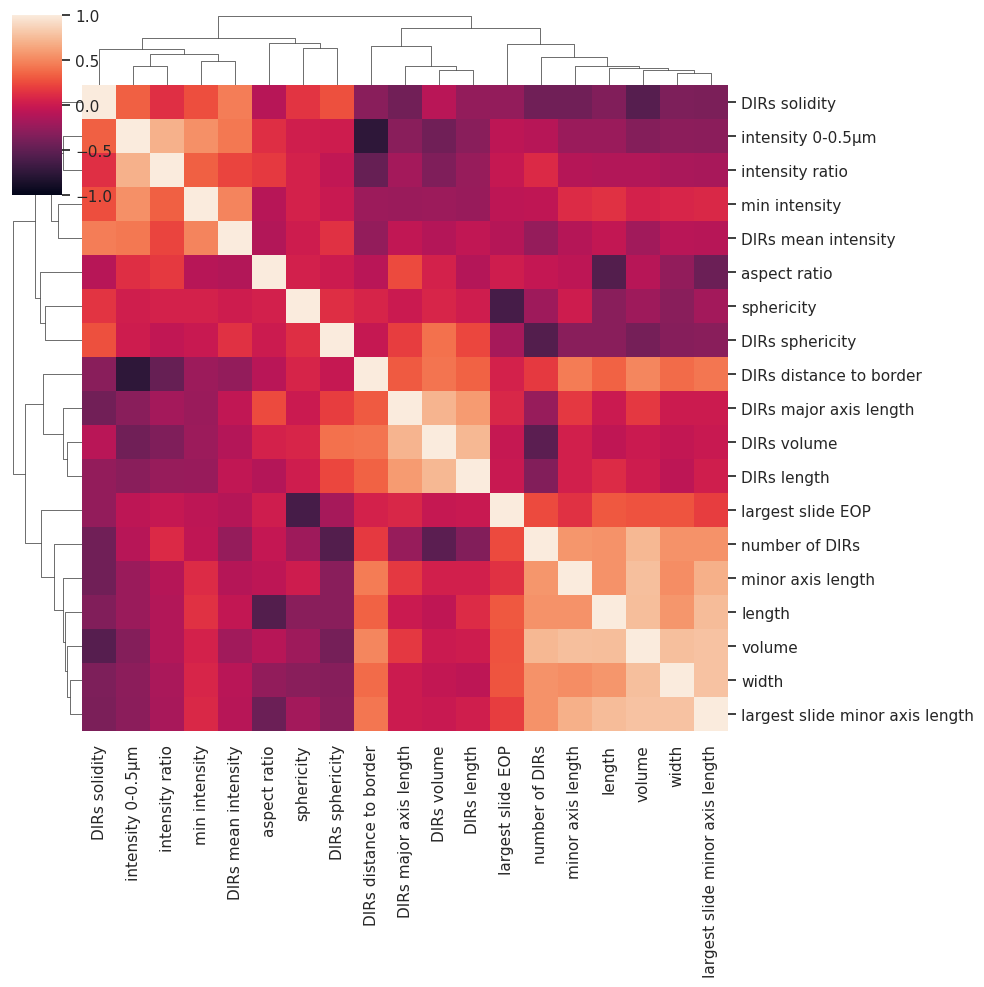

In [13]:
sns.clustermap(
    subset_df[sig_f_both].corr(), dendrogram_ratio=0.1, vmin=-1, vmax=1
)

In [14]:
subset_df.reset_index(drop=True, inplace=True)
subset_df.condition.value_counts()

MP           254
Young        177
Aged         164
Aged + Ri    144
Name: condition, dtype: int64

[[Text(2.0, 0, ''),
  Text(4.0, 0, ''),
  Text(6.0, 0, ''),
  Text(8.0, 0, ''),
  Text(10.0, 0, ''),
  Text(12.0, 0, ''),
  Text(14.0, 0, '')],
 [Text(0, 2.0, ''),
  Text(0, 4.0, ''),
  Text(0, 6.0, ''),
  Text(0, 8.0, ''),
  Text(0, 10.0, ''),
  Text(0, 12.0, ''),
  Text(0, 14.0, '')]]

<Figure size 1000x600 with 0 Axes>

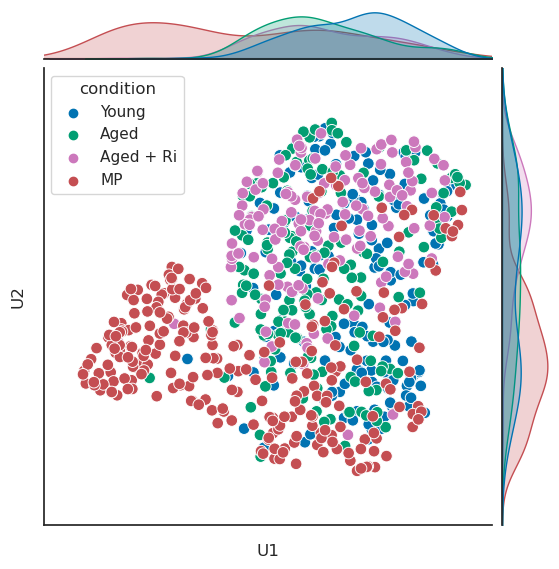

In [15]:
from sklearn.preprocessing import StandardScaler

sns.set_style("white")
# Create the UMAP object
reducer = umap.UMAP(
    min_dist=0.3,
    n_neighbors=15,
    n_components=2,
    random_state=2024,
    metric="euclidean",
)

# Extract numerical data
x = subset_df[sig_f_both].values

# Learn the scaler on the young and confined cells and apply
# it to the old and treated cells
transformer = StandardScaler()
x = transformer.fit_transform(x)

# Learn the UMAP on the young and confined cells and apply
# it to the old and treated cells
embedding = reducer.fit_transform(x)
umap_df = pd.DataFrame(data=embedding, columns=["U1", "U2"])
umap_df = pd.concat([umap_df, subset_df[features]], axis=1)

plt.figure(figsize=(10, 6))
plot = sns.jointplot(
    data=umap_df,
    x="U1",
    y="U2",
    hue="condition",
    s=70,
    palette=palette,
    height=6,
    ratio=8,
)
plot.ax_marg_x.set_xlim(2, 13)
plot.ax_marg_y.set_ylim(3, 13)
plot.ax_joint.set(xticklabels=[], yticklabels=[])

[[Text(2.0, 0, ''),
  Text(4.0, 0, ''),
  Text(6.0, 0, ''),
  Text(8.0, 0, ''),
  Text(10.0, 0, ''),
  Text(12.0, 0, ''),
  Text(14.0, 0, '')],
 [Text(0, 2.0, ''),
  Text(0, 4.0, ''),
  Text(0, 6.0, ''),
  Text(0, 8.0, ''),
  Text(0, 10.0, ''),
  Text(0, 12.0, ''),
  Text(0, 14.0, '')]]

<Figure size 1000x600 with 0 Axes>

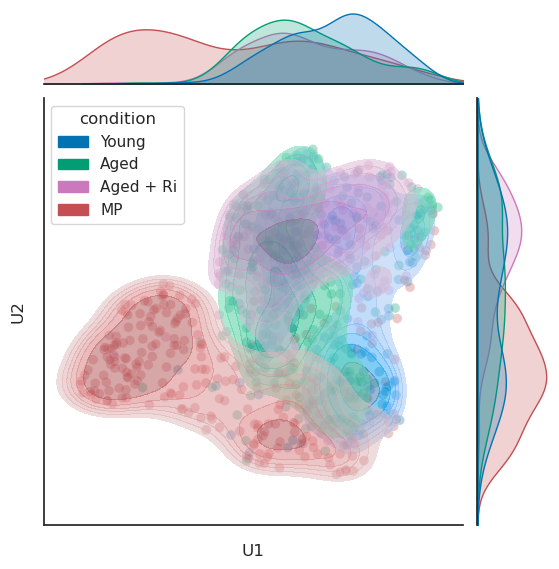

In [16]:
plt.figure(figsize=(10, 6))
plot = sns.jointplot(
    data=umap_df,
    x="U1",
    y="U2",
    hue="condition",
    kind="scatter",
    s=50,
    palette=palette,
    alpha=0.3,
)
plot.plot_joint(
    sns.kdeplot,
    data=umap_df,
    hue="condition",
    kind="kde",
    fill=True,
    levels=7,
    thresh=0.3,
    alpha=0.5,
    bw_adjust=0.75,
    palette=palette,
)

plot.ax_marg_x.set_xlim(2, 13)
plot.ax_marg_y.set_ylim(3, 13)
plot.ax_joint.set(xticklabels=[], yticklabels=[])

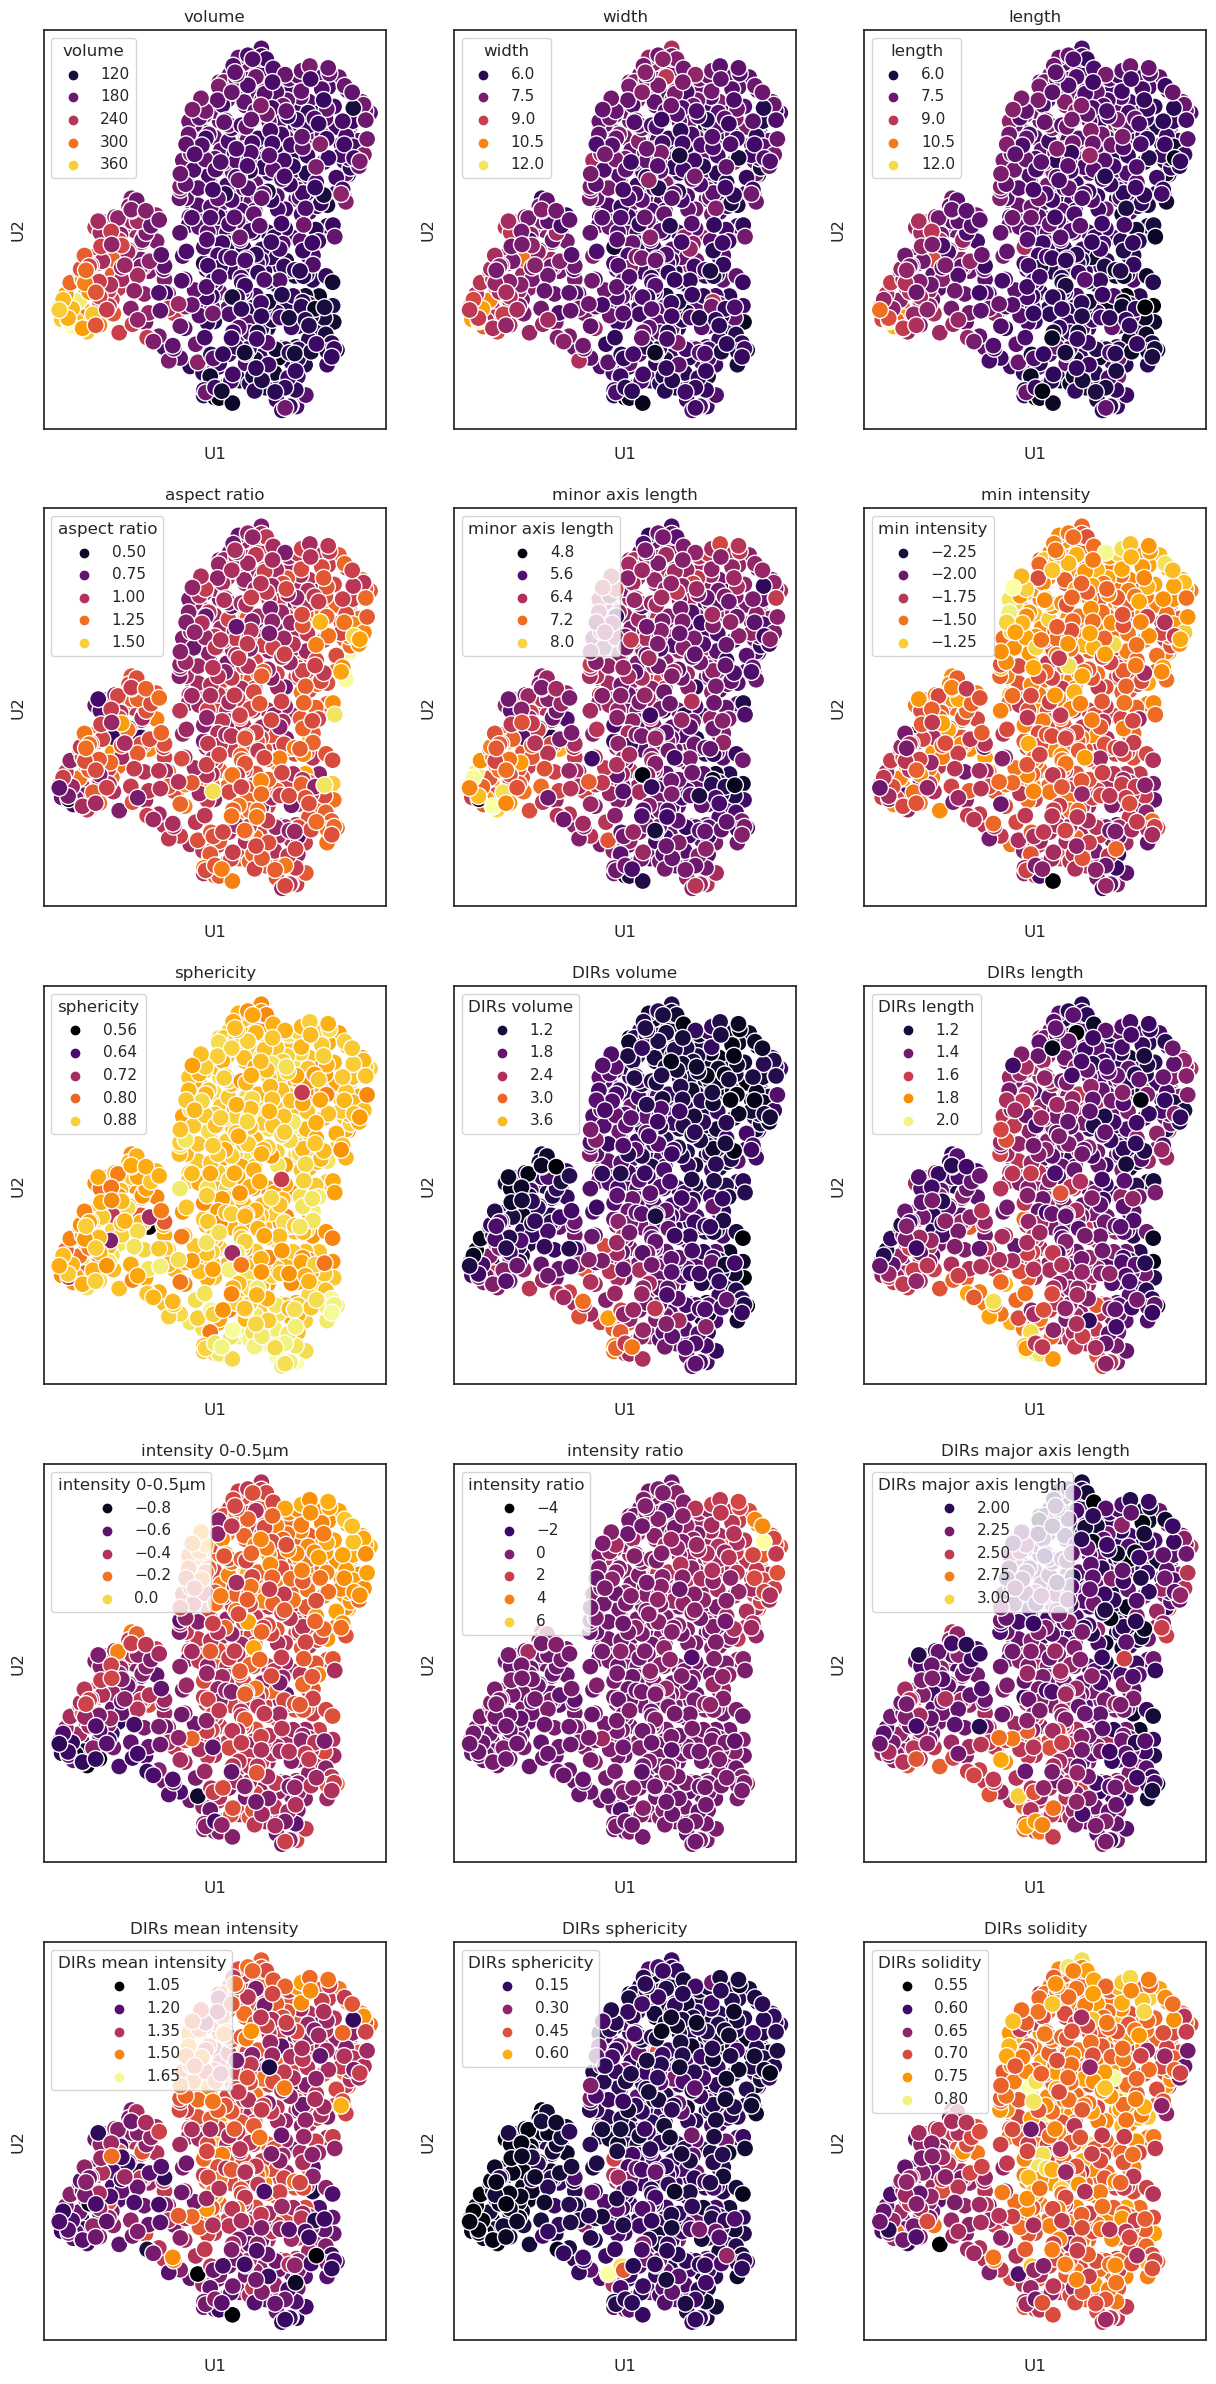

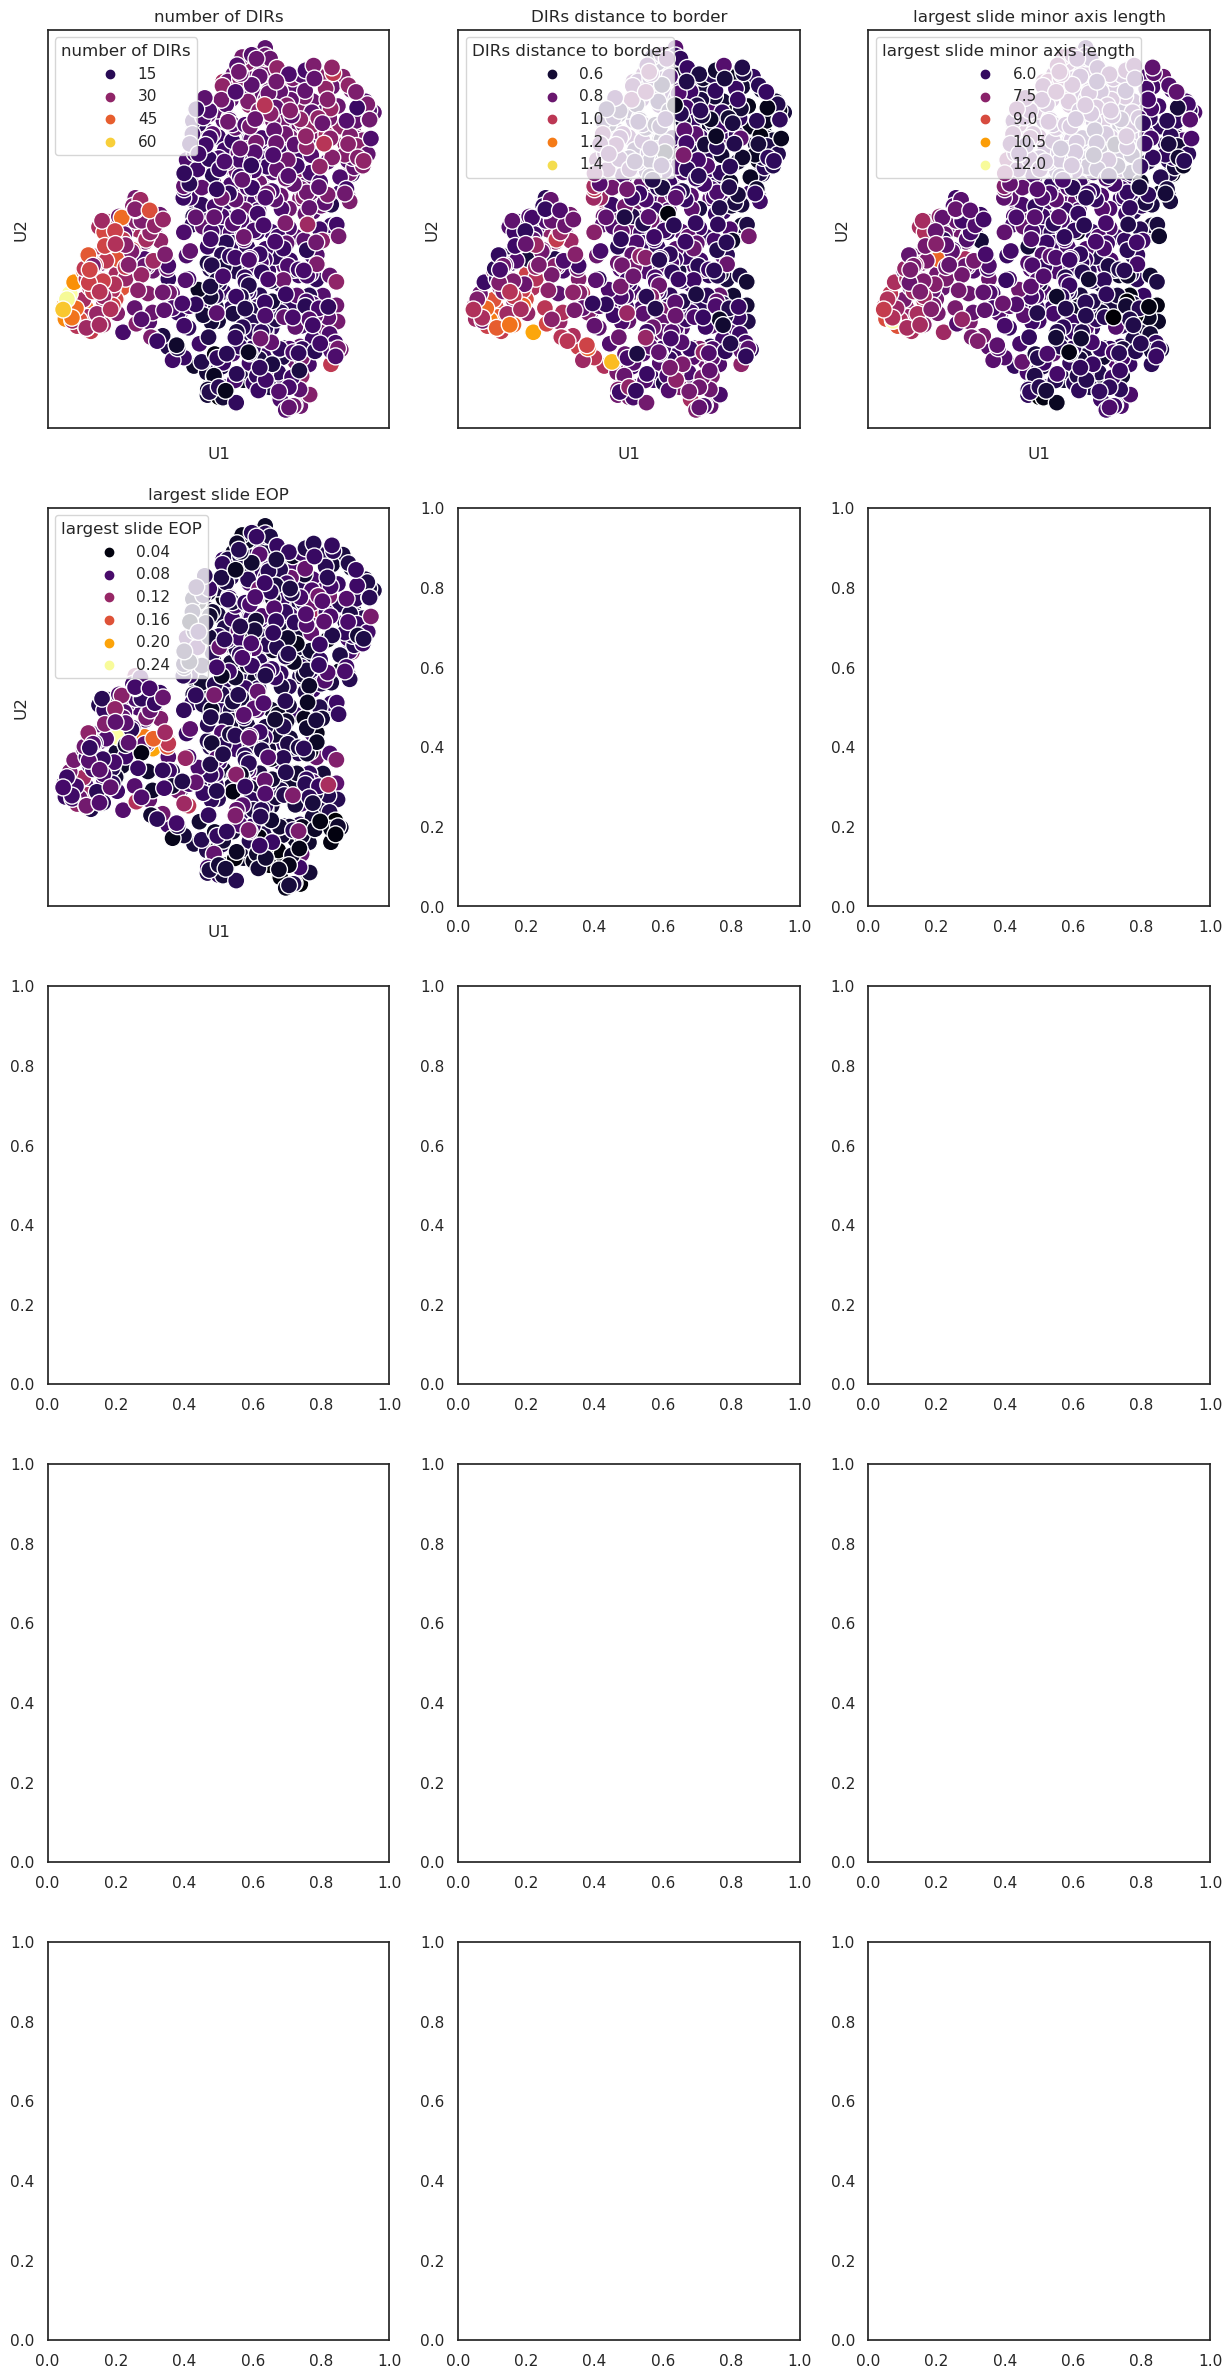

In [17]:
# Prepare to export the plots as a pdf file
pdf = PdfPages(f"../results/ZSCORENORM_umaps_{res}_cft{cft}_MP.pdf")

fig, axs = plt.subplots(5, 3, figsize=(15, 30), facecolor="white")
axs = axs.flat

i = 0

# Plot the UMAPs for the effect of each feature
for m in sig_f_both:
    if (i + 1) % 16 == 0:
        pdf.savefig()
        fig, axs = plt.subplots(5, 3, figsize=(15, 30), facecolor="white")
        axs = axs.flat
        i = 0

    sns.scatterplot(
        data=umap_df,
        x="U1",
        y="U2",
        hue=m,
        s=150,
        ax=axs[i],
        legend=True,
        palette="inferno",
    )
    axs[i].title.set_text(m)
    axs[i].set(xticklabels=[], yticklabels=[])
    i += 1

pdf.savefig()
pdf.close()

In [18]:
# Perform clustering using the original numerical values
X = pd.DataFrame(x, columns=sig_f_both)
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
umap_df["Cluster"] = kmeans.labels_
umap_df["Cluster"] = umap_df["Cluster"].astype("category")
mapping = {0: "HSC", 1: "MP1", 2: "MP2", 3: "Mix"}
umap_df["Cluster"] = umap_df["Cluster"].cat.rename_categories(mapping)

[[Text(0.0, 0, ''),
  Text(2.0, 0, ''),
  Text(4.0, 0, ''),
  Text(6.0, 0, ''),
  Text(8.0, 0, ''),
  Text(10.0, 0, ''),
  Text(12.0, 0, ''),
  Text(14.0, 0, ''),
  Text(16.0, 0, '')],
 [Text(0, 2.0, ''),
  Text(0, 4.0, ''),
  Text(0, 6.0, ''),
  Text(0, 8.0, ''),
  Text(0, 10.0, ''),
  Text(0, 12.0, ''),
  Text(0, 14.0, '')]]

<Figure size 1000x600 with 0 Axes>

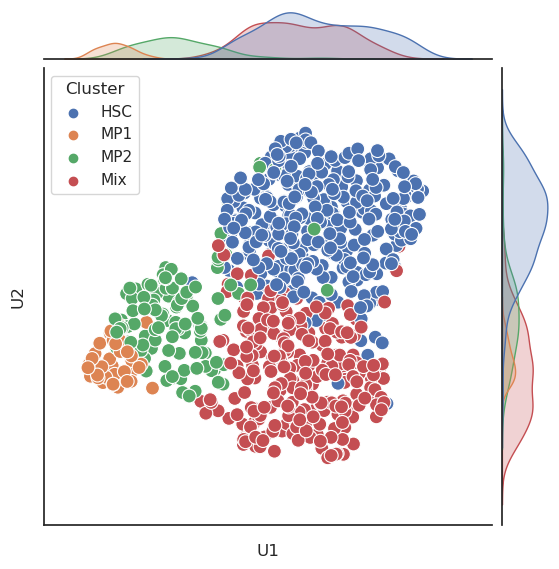

In [19]:
plt.figure(figsize=(10, 6))

plot = sns.jointplot(
    data=umap_df, x="U1", y="U2", hue="Cluster", s=100, height=6, ratio=8
)
plot.ax_joint.set(xticklabels=[], yticklabels=[])

In [20]:
umap_df.Cluster.value_counts()

HSC    334
Mix    256
MP2    111
MP1     38
Name: Cluster, dtype: int64

TypeError: silhouette_plot() takes 3 positional arguments but 4 were given

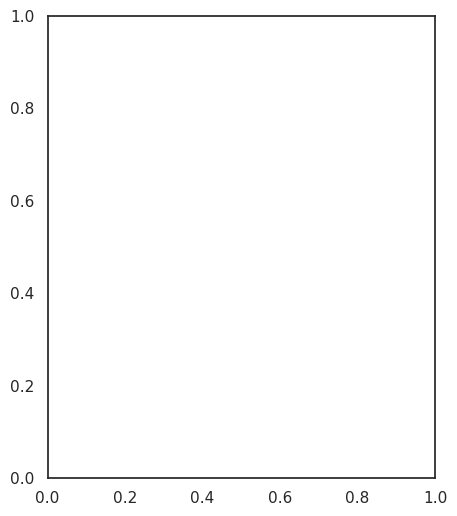

In [21]:
# Plot the silhouette chart to assess the clustering quality
clus_pal = {"HSC": "khaki", "MP1": "navy", "MP2": "darkred", "Mix": "sienna"}

fig, ax = plt.subplots(figsize=(5, 6))
hsc.silhouette_plot(x, kmeans, ax, clus_pal)

Text(0, 0.5, 'Number of HSC per condition')

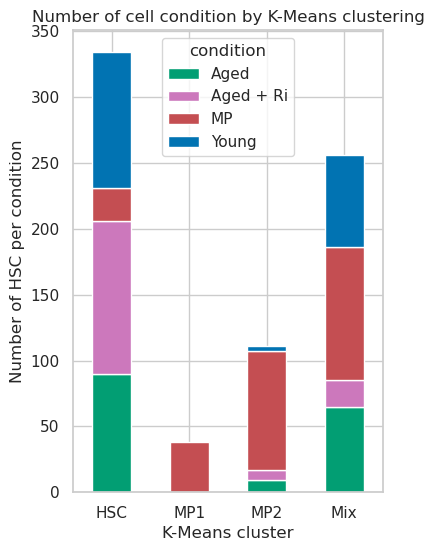

In [23]:
sns.set(rc={"figure.figsize": (4, 6)})
sns.set_style("whitegrid")

subset_df["Cluster"] = kmeans.labels_
subset_df["Cluster"] = subset_df["Cluster"].astype("category")
mapping = {0: "HSC", 1: "MP1", 2: "MP2", 3: "Mix"}
subset_df["Cluster"] = subset_df["Cluster"].cat.rename_categories(mapping)
# Build dataframe of grouped variables (can I make it shorter and more elegant?)
toplot = hsc.groupby_and_count(subset_df, group1="Cluster", group2="condition")
toplot = toplot.fillna(0)

# Make color consistent with the UMAP conditions colors
toplot.plot(kind="bar", stacked=True, color=palette)
plt.title("Number of cell condition by K-Means clustering")
plt.xlabel("K-Means cluster")
plt.xticks(rotation=0)
plt.ylabel("Number of HSC per condition")

Text(0, 0.5, 'Percentage of HSC per condition (%)')

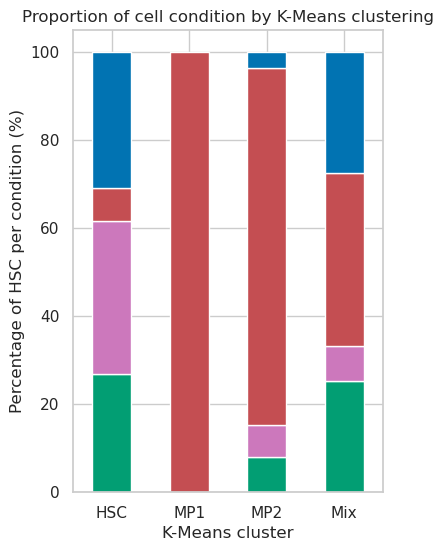

In [24]:
# Plot in percentages instead of absolute numbers
stacked = toplot.apply(lambda x: x * 100 / sum(x), axis=1)
stacked.plot(kind="bar", stacked=True, color=palette, legend=False)
plt.title("Proportion of cell condition by K-Means clustering")
plt.xlabel("K-Means cluster")
plt.xticks(rotation=0)
plt.ylabel("Percentage of HSC per condition (%)")

[[Text(2.0, 0, ''),
  Text(4.0, 0, ''),
  Text(6.0, 0, ''),
  Text(8.0, 0, ''),
  Text(10.0, 0, ''),
  Text(12.0, 0, ''),
  Text(14.0, 0, '')],
 [Text(0, 2.0, ''),
  Text(0, 4.0, ''),
  Text(0, 6.0, ''),
  Text(0, 8.0, ''),
  Text(0, 10.0, ''),
  Text(0, 12.0, ''),
  Text(0, 14.0, '')]]

<Figure size 1000x600 with 0 Axes>

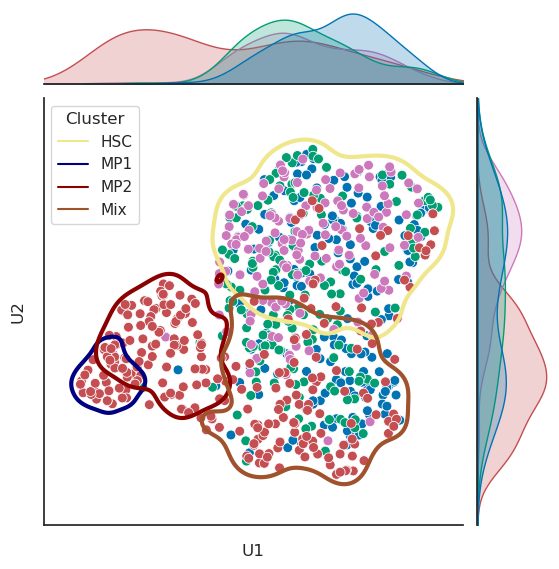

In [25]:
plt.figure(figsize=(10, 6))
sns.set_style("white")

umap_df["Cluster"] = umap_df["Cluster"].astype("category")

plot = sns.jointplot(
    data=umap_df,
    x="U1",
    y="U2",
    hue="condition",
    kind="scatter",
    s=50,
    palette=palette,
)
sns.kdeplot(
    data=umap_df,
    x="U1",
    y="U2",
    hue="Cluster",
    kind="kde",
    fill=False,
    levels=2,
    thresh=0.13,
    linewidths=3,
    bw_adjust=0.75,
    palette=clus_pal,
)

plot.ax_marg_x.set_xlim(2, 13)
plot.ax_marg_y.set_ylim(3, 13)
plot.ax_joint.set(xticklabels=[], yticklabels=[])

[[Text(2.0, 0, ''),
  Text(4.0, 0, ''),
  Text(6.0, 0, ''),
  Text(8.0, 0, ''),
  Text(10.0, 0, ''),
  Text(12.0, 0, ''),
  Text(14.0, 0, '')],
 [Text(0, 2.0, ''),
  Text(0, 4.0, ''),
  Text(0, 6.0, ''),
  Text(0, 8.0, ''),
  Text(0, 10.0, ''),
  Text(0, 12.0, ''),
  Text(0, 14.0, '')]]

<Figure size 1000x600 with 0 Axes>

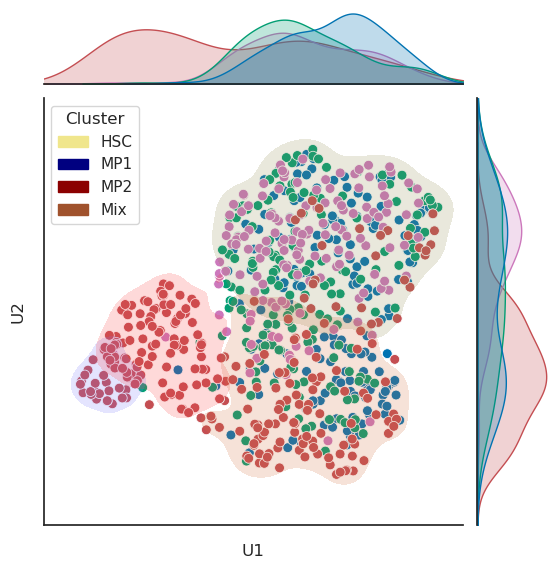

In [26]:
plt.figure(figsize=(10, 6))
sns.set_style("white")

plot = sns.jointplot(
    data=umap_df,
    x="U1",
    y="U2",
    hue="condition",
    kind="scatter",
    s=50,
    palette=palette,
)
sns.kdeplot(
    data=umap_df,
    x="U1",
    y="U2",
    hue="Cluster",
    kind="kde",
    fill=True,
    alpha=0.2,
    levels=2,
    linewidths=3,
    thresh=0.13,
    bw_adjust=0.75,
    palette=clus_pal,
)

plot.ax_marg_x.set_xlim(2, 13)
plot.ax_marg_y.set_ylim(3, 13)
plot.ax_joint.set(xticklabels=[], yticklabels=[])

In [28]:
pv_df = hsc.get_p_values_clusters(
    subset_df,
    subset_df.columns[:-5],
    by_col="Cluster",
    group="HSC",
)

In [29]:
pv_df.sort_values(by="p_float", ascending=True)

p_float p_string significance  <0.05  \
intensity 0-0.5µm                 1.723290e-83  0.00000          ***   True   
intensity 1-1.5µm                 7.328999e-69  0.00000          ***   True   
intensity ratio                   2.317158e-62  0.00000          ***   True   
min intensity                     1.701060e-50  0.00000          ***   True   
DIRs centroid distance to border  6.476317e-50  0.00000          ***   True   
DIRs distance to border           2.006988e-46  0.00000          ***   True   
DIRs volume                       1.038918e-41  0.00000          ***   True   
DIRs major axis length            1.726606e-41  0.00000          ***   True   
DIRs height                       2.456492e-37  0.00000          ***   True   
DIRs mean intensity               2.497063e-33  0.00000          ***   True   
DIRs solidity                     6.279129e-28  0.00000          ***   True   
DIRs width                        8.684546e-27  0.00000          ***   True   
DIRs max intensity                2.446812e-24  0.00000          ***   True   
DIRs length                       2.598044e-24  0.00000          ***   True   
DIRs surface area                 1.941908e-07  0.00000          ***   True   
aspect ratio                      2.793954e-07  0.00000          ***   True   
number of DIRs                    5.596009e-07  0.00000          ***   True   
height deviation                  6.022531e-07  0.00000          ***   True   
max intensity                     4.561414e-06  0.00000          ***   True   
height                            6.125945e-06  0.00001          ***   True   
DIRs aspect ratio                 9.348725e-03  0.00935           **   True   
largest slide major axis length   5.471930e-02  0.05472           ns  False   
length                            7.390019e-02  0.07390           ns  False   
largest slide compactness         8.173465e-02  0.08173           ns  False   
largest slide area                8.919090e-02  0.08919           ns  False   
largest slide EOP                 1.240095e-01  0.12401           ns  False   
invagination proportion           1.868249e-01  0.18682           ns  False   
solidity                          1.868249e-01  0.18682           ns  False   
largest slide perimeter           1.896130e-01  0.18961           ns  False   
DIRs surface/volume               3.990823e-01  0.39908           ns  False   
minor axis length                 4.467426e-01  0.44674           ns  False   
largest slide roundness           4.946363e-01  0.49464           ns  False   
sphericity                        5.597338e-01  0.55973           ns  False   
DIRs sphericity                   5.637024e-01  0.56370           ns  False   
volume                            7.528353e-01  0.75284           ns  False   
width                             8.042839e-01  0.80428           ns  False   
major axis length                 8.312418e-01  0.83124           ns  False   
surface area                      8.331327e-01  0.83313           ns  False   
largest slide minor axis length   8.390817e-01  0.83908           ns  False   

                                  <0.01  <0.001  
intensity 0-0.5µm                  True    True  
intensity 1-1.5µm                  True    True  
intensity ratio                    True    True  
min intensity                      True    True  
DIRs centroid distance to border   True    True  
DIRs distance to border            True    True  
DIRs volume                        True    True  
DIRs major axis length             True    True  
DIRs height                        True    True  
DIRs mean intensity                True    True  
DIRs solidity                      True    True  
DIRs width                         True    True  
DIRs max intensity                 True    True  
DIRs length                        True    True  
DIRs surface area                  True    True  
aspect ratio                       True    True  
number of DIRs              

In [30]:
X["Cluster"] = umap_df["Cluster"]

X_log2fc = hsc.calculate_logfoldchange(X)
X_log2fc

HSC       MP1       MP2       Mix
volume                          -0.880507  1.433243  0.060962 -1.359673
width                           -0.611094  1.201575  0.083782 -1.211048
length                          -0.539681  1.178418  0.115513 -1.315073
aspect ratio                    -0.076836 -0.601713  0.124253  0.452570
minor axis length               -0.647750  1.162804  0.110834 -1.125603
min intensity                    0.830756 -0.527673  0.085021 -0.614573
sphericity                       0.353374 -0.645562 -0.395245  0.520505
DIRs volume                     -0.693619  0.120654 -0.082499  0.521828
DIRs length                     -0.590814  0.060297  0.106892  0.339955
intensity 0-0.5µm                1.576377 -3.711253 -0.323297  0.122833
intensity ratio                  0.868078 -0.476856 -0.353276 -0.227906
DIRs major axis length          -0.834523  0.305434  0.137129  0.240401
DIRs mean intensity              1.011883 -1.571184 -0.224708  0.187959
DIRs sphericity                  0.312079 -1.533422 -0.311004  0.953249
DIRs solidity                    1.334081      -inf -0.845645  0.920802
number of DIRs                  -0.500617  1.204411  0.088532 -1.384691
DIRs distance to border         -1.113332  1.001060  0.101743 -0.389352
largest slide minor axis length -0.651853  1.231992  0.106990 -1.266712
largest slide EOP               -0.433790  0.506514  0.375644 -0.614386

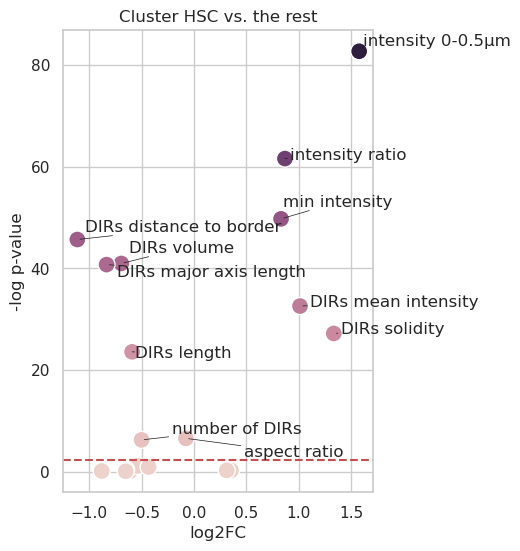

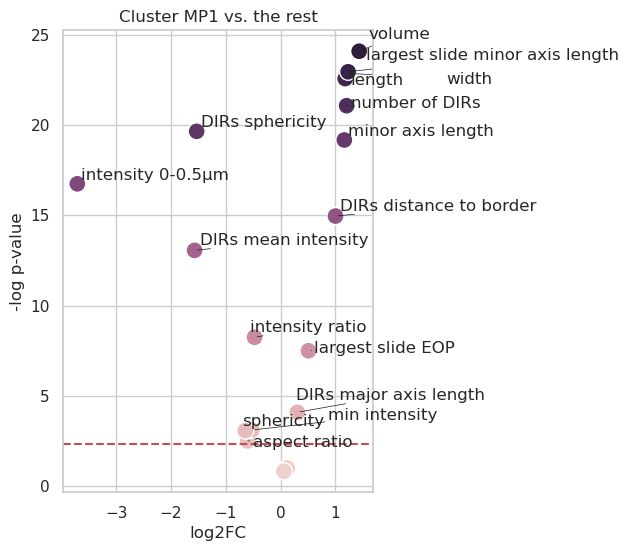

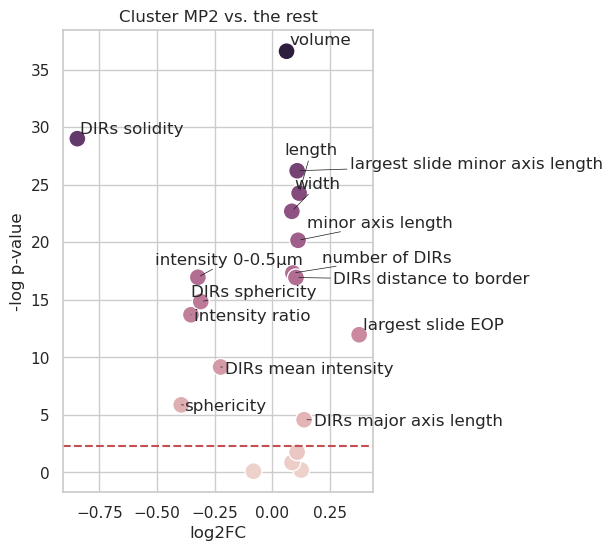

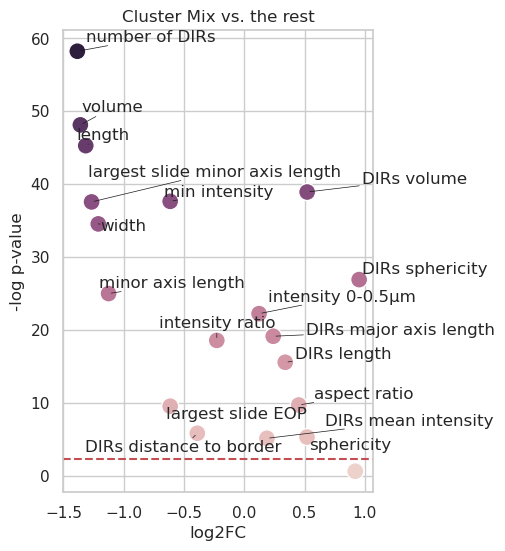

In [31]:
from adjustText import adjust_text

sns.set(font_scale=1)
sns.set_style("whitegrid")

signif = 0.005

for c in np.unique(umap_df["Cluster"]):

    pv_df = hsc.get_p_values_clusters(
        subset_df,
        subset_df.columns[:-5],
        by_col="Cluster",
        group=c,
    )

    pv_df = pv_df.loc[X_log2fc.index]
    df = pd.concat([X_log2fc[c], pv_df["p_float"]], axis=1)
    df.columns = ["log2FC", "p_value"]

    sns.scatterplot(
        x=df["log2FC"],
        y=df["p_value"].apply(lambda x: -np.log10(x)),
        hue=df["p_value"].apply(lambda x: -np.log10(x)),
        s=150,
        legend=False,
    )

    texts = []
    for i, r in df.iterrows():
        if r["p_value"] < signif:
            texts.append(
                plt.text(x=r["log2FC"], y=-np.log10(r["p_value"]), s=i)
            )
    adjust_text(
        texts,
        arrowprops=dict(arrowstyle="-", color="k", lw=0.5),
        ensure_inside_axes=False,
    )

    plt.xlabel("log2FC")
    plt.ylabel("-log p-value")
    plt.axhline(-np.log10(signif), color="r", linestyle="--")
    plt.title(f"Cluster {c} vs. the rest")
    plt.show()

In [32]:
sig_f = pv_df[pv_df["<0.05"]].index.to_list()
sig_f

['volume',
 'width',
 'length',
 'aspect ratio',
 'minor axis length',
 'min intensity',
 'sphericity',
 'DIRs volume',
 'DIRs length',
 'intensity 0-0.5µm',
 'intensity ratio',
 'DIRs major axis length',
 'DIRs mean intensity',
 'DIRs sphericity',
 'number of DIRs',
 'DIRs distance to border',
 'largest slide minor axis length',
 'largest slide EOP']

In [33]:
subset_df["Cluster"] = subset_df["Cluster"].astype("category")

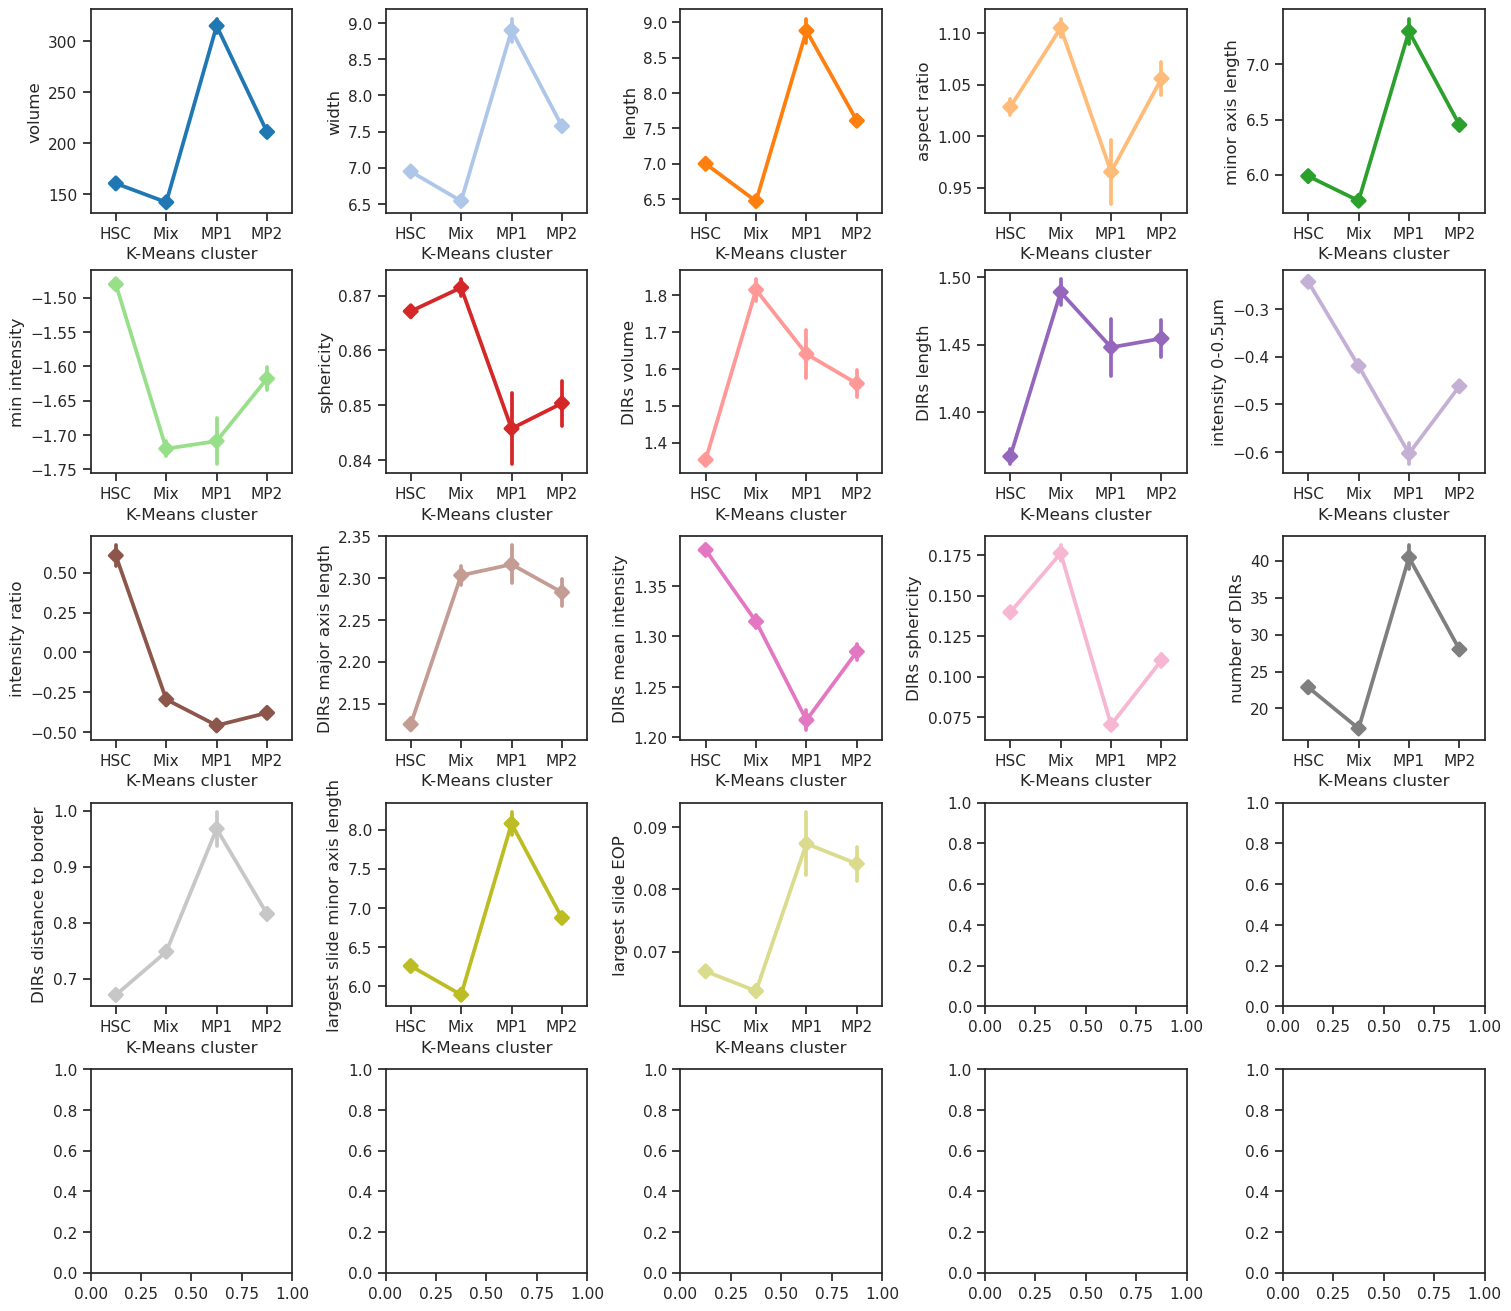

In [34]:
sns.set_style("ticks")

pal = (
    sns.color_palette("tab20")
    + sns.color_palette("tab20b")
    + sns.color_palette("tab20c")
)
fig, axes = plt.subplots(5, 5, figsize=(15, 13), constrained_layout=True)

for m, p, a in zip(sig_f, pal, axes.flatten()):
    b = sns.pointplot(
        ax=a,
        data=subset_df,
        x="Cluster",
        y=m,
        markers="D",
        dodge=False,
        errorbar="se",
        color=p,
        order=["HSC", "Mix", "MP1", "MP2"],
    )
    b.set_xlabel("K-Means cluster")

plt.show()